In [ ]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append("../")
import json
import numpy as np

import torch
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from skimage.transform import resize

from bbox import BBox2D, XYXY
from bbox.metrics import jaccard_index_2d

from scipy.optimize import linear_sum_assignment

from lib.data.refcoco_dataset import RefCOCO

In [ ]:
matplotlib.rcParams['figure.dpi'] = 150

In [ ]:
# Utils

def getRandomColor():    
    color = np.random.rand(3)
    return color

In [2]:
grcnn_preds = torch.load("../results/predictions.pth") # grcnn obj bboxes
grcnn_rel_preds = torch.load("../results/predictions_pred.pth") # relationship predictions
bottom_up_preds = torch.load("/projectnb/llamagrp/shawnlin/ref-exp-gen/test-detectron/results/predictions.pts") # attribute predictions

NameError: name 'torch' is not defined

In [ ]:
# RefCOCO dataset loader

dataset = RefCOCO(split="test")
data_loader = DataLoader(dataset, shuffle=False)

In [ ]:
# G-RCNN class/relationship vocabulary

info = json.load(open("/projectnb/llamagrp/shawnlin/ref-exp-gen/graph-rcnn.pytorch/datasets/vg_bm/VG-SGG-dicts.json", 'r'))
info['label_to_idx']['__background__'] = 0
class_to_ind = info['label_to_idx']
ind_to_classes = sorted(class_to_ind, key=lambda k: class_to_ind[k])

predicate_to_ind = info['predicate_to_idx']
predicate_to_ind['__background__'] = 0
predicate_to_ind = info['predicate_to_idx']
ind_to_predicates = sorted(predicate_to_ind, key=lambda k:predicate_to_ind[k])

In [ ]:
# Bottom-up class/attribute vocabulary

data_path = "/projectnb/llamagrp/shawnlin/ref-exp-gen/bottom-up-attention/data/genome/1600-400-20"

vg_classes = []
with open(os.path.join(data_path, 'objects_vocab.txt')) as f:
    for object in f.readlines():
        vg_classes.append(object.split(',')[0].lower().strip())

vg_attrs = []
with open(os.path.join(data_path, 'attributes_vocab.txt')) as f:
    for object in f.readlines():
        vg_attrs.append(object.split(',')[0].lower().strip())

BoxList(num_boxes=30, image_width=640, image_height=461, mode=xyxy)
BoxPairList(num_boxes=256, image_width=640, image_height=461, mode=xyxy)
{0: 'shirt-1', 1: 'man-1', 2: 'elephant-1', 3: 'hair-1', 4: 'trunk-1', 5: 'pant-1', 6: 'short-1', 7: 'eye-1', 8: 'head-1', 9: 'head-2', 10: 'arm-1', 11: 'woman-1', 12: 'shoe-1', 13: 'person-1', 14: 'boot-1', 15: 'pant-2', 16: 'face-1', 17: 'tree-1'}


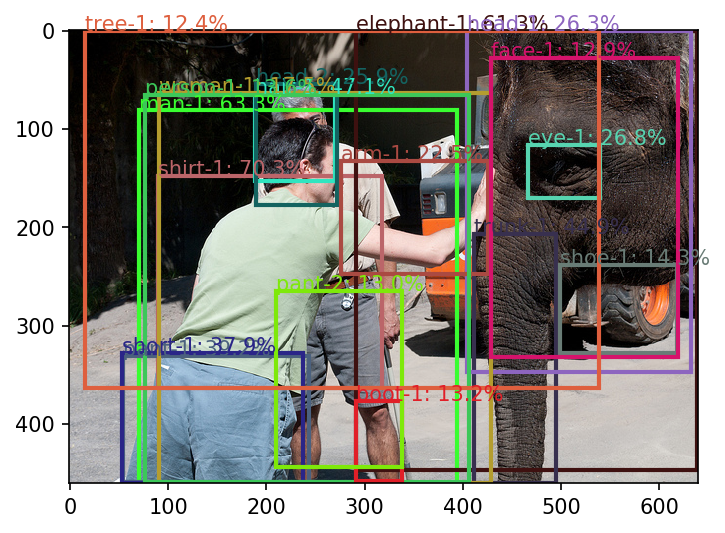

In [82]:
# Visualize G-RCNN results

for i, (img, _, _) in enumerate(iter(dataset)):

    preds = grcnn_preds[i]
    rel_preds = grcnn_rel_preds[i]
    print(preds)
    print(rel_preds)

    plt.imshow(img)
    ax = plt.gca()
    bboxes = preds.bbox
    labels = preds.extra_fields["labels"]
    scores = preds.extra_fields["scores"]
    class_cntr = {}
    class_alias_map = {} # j: class_alias
    
    # Draw object bboxes
    for j, (bbox, label, score) in enumerate(zip(bboxes, labels, scores)):
        if score < 0.1: continue

        rand_color = getRandomColor()
        # Create a Rectangle patch
        rect = Rectangle((bbox[0],bbox[1]),bbox[2]-bbox[0], bbox[3]-bbox[1],linewidth=2,edgecolor=rand_color, facecolor="none")
        
        class_name = ind_to_classes[label.item()]
        class_cntr[class_name] = class_cntr.get(class_name, 0) + 1
        class_alias = "%s-%i" % (class_name, class_cntr[class_name])
        class_alias_map[j] = class_alias
        plt.text(bbox[0], bbox[1], "%s: %.1f%%" % (class_alias, score*100), color=rand_color)
        # Add the patch to the Axes
        ax.add_patch(rect)
    print(class_alias_map)
    plt.show()
    
    # Show relationships
    
    break

BoxList(num_boxes=13, image_width=1111, image_height=800, mode=xyxy)


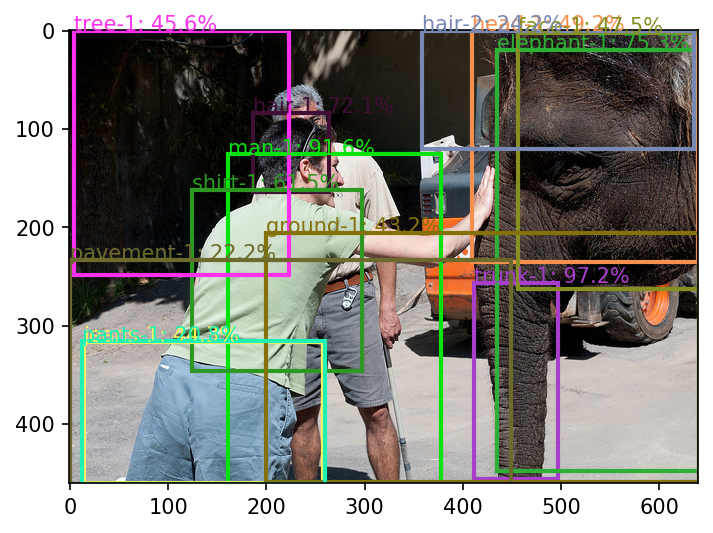

In [81]:
# Visualize bottom-up attention results

for i, (img, _, _) in enumerate(iter(dataset)):

    preds = bottom_up_preds[i]
    print(preds)

    #img = resize(img, (preds.size[1], preds.size[0]))
    plt.imshow(img)
    ax = plt.gca()
    bboxes = preds.bbox
    labels = preds.extra_fields["labels"]
    scores = preds.extra_fields["scores"]
    attr_logits = preds.extra_fields["attr_logits"]
    
    class_cntr = {}
    class_alias_map = {} # j: class_alias
    for j, (bbox, label, score, attr_logit) in enumerate(zip(bboxes, labels, scores, attr_logits)):
        if score < 0.2: continue

        rand_color = getRandomColor()
        # Create a Rectangle patch
        rect = Rectangle((bbox[0],bbox[1]),bbox[2]-bbox[0], bbox[3]-bbox[1],linewidth=2,edgecolor=rand_color, facecolor="none")
        
        class_name = vg_classes[label.item()]
        class_cntr[class_name] = class_cntr.get(class_name, 0) + 1
        class_alias = "%s-%i" % (class_name, class_cntr[class_name])
        class_alias_map[j] = class_alias
        plt.text(bbox[0], bbox[1], "%s: %.1f%%" % (class_alias, score*100), color=rand_color)
        #plt.text(bbox[0], bbox[1], "%s: %.1f%%" % (label, score*100), color=rand_color)
        # Add the patch to the Axes
        ax.add_patch(rect)
    plt.show()
    break

In [201]:
# Create iou cost matrix for two sets of predictions

def get_iou_score(b1, b2):
    
    b1 = BBox2D(b1.numpy(), mode=XYXY)
    b2 = BBox2D(b2.numpy(), mode=XYXY)
    return jaccard_index_2d(b1, b2)

    
def create_cost_matrix(pred1, pred2, thresh=0.2):
    """
    pred1, pred2: BoxList
    """
    
    n_bbox1, n_bbox2 = len(pred1), len(pred2)
    print(n_bbox1, n_bbox2)
    
    M_cost = np.ones((n_bbox1, n_bbox2)) * 999999.9
    
    thresh=0.0
    for i in range(n_bbox1):
        for j in range(n_bbox2):
            if pred1.extra_fields["scores"][i] >= thresh and pred2.extra_fields["scores"][j] >= thresh:# and\
                #ind_to_classes[pred1.extra_fields["labels"][i]] == vg_classes[pred2.extra_fields["labels"][j]]:
                iou_score = get_iou_score(pred1.bbox[i], pred2.bbox[j])
            else:
                iou_score = 0.0
            #print(i, j)
            M_cost[i][j] = -1*iou_score
    return M_cost

ii = 0
M_cost = create_cost_matrix(grcnn_preds[ii], bottom_up_preds[ii])
row_ind, col_ind = linear_sum_assignment(M_cost)
print(M_cost.shape)
print(M_cost)
print(row_ind)
print(col_ind)

30 13
(30, 13)
[[ 0.         -0.38717557  0.         -0.02503314 -0.64685384  0.
   0.         -0.15066811 -0.10576238 -0.13307037 -0.         -0.24673622
  -0.10744218]
 [ 0.         -0.59118056  0.         -0.05191767 -0.26175441  0.
   0.         -0.16943344 -0.2062011  -0.2677397  -0.00935748 -0.48550871
  -0.20857159]
 [-0.10639694 -0.13997787 -0.55935938  0.         -0.00689694 -0.34756177
  -0.30570128  0.          0.         -0.45939466 -0.21499792 -0.15186098
   0.        ]
 [-0.         -0.02951643  0.         -0.63103312  0.          0.
   0.         -0.05363283  0.          0.          0.          0.
   0.        ]
 [-0.77697603  0.         -0.1566246  -0.          0.         -0.03407949
  -0.03368875  0.          0.         -0.19114141  0.         -0.07628422
   0.        ]
 [ 0.         -0.12487821  0.          0.         -0.0354602  -0.
  -0.          0.         -0.69521067 -0.04437703 -0.         -0.23981714
  -0.68098881]
 [ 0.         -0.117363    0.          0.      

BoxList(num_boxes=30, image_width=640, image_height=461, mode=xyxy)
BoxPairList(num_boxes=256, image_width=640, image_height=461, mode=xyxy)
{0: 'shirt-1', 1: 'man-1', 2: 'elephant-1', 3: 'hair-1', 4: 'trunk-1', 5: 'pant-1', 6: 'short-1', 7: 'eye-1', 8: 'head-1', 9: 'head-2', 10: 'arm-1', 11: 'woman-1', 12: 'shoe-1', 13: 'person-1', 14: 'boot-1', 15: 'pant-2', 16: 'face-1', 17: 'tree-1', 18: 'hat-1', 19: 'street-1', 20: 'face-2', 21: 'hair-2', 22: 'jacket-1', 23: 'tree-2', 24: 'sidewalk-1', 25: 'fence-1', 26: 'leg-1', 27: 'eye-2', 28: 'boy-1', 29: 'man-2'}


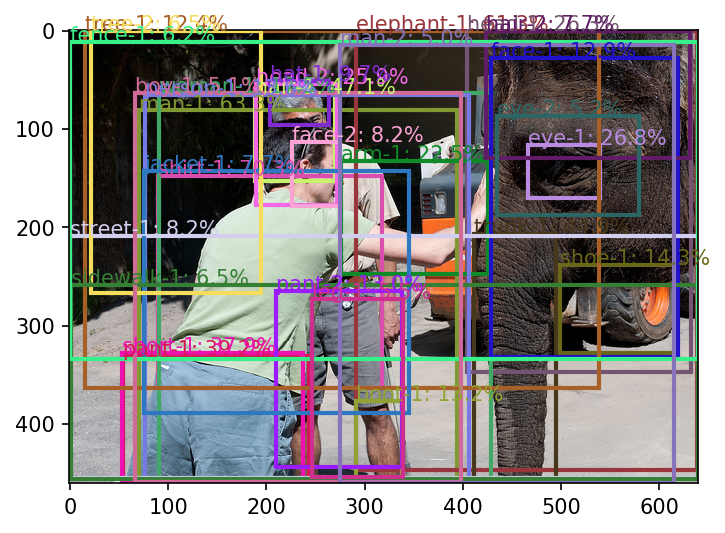

BoxList(num_boxes=30, image_width=640, image_height=461, mode=xyxy)


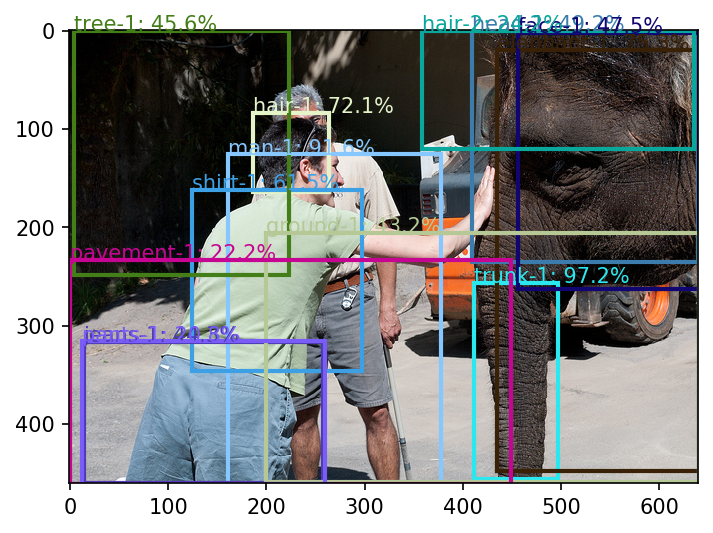

30 13
[ 0  1  2  3  4  5  6  8 16 19 21 23 24]
[ 4  1  2  3  0  8 12  5  6  9 10  7 11]
shirt-1 <----> shirt-1
man-1 <----> man-1
elephant-1 <----> elephant-1
hair-1 <----> hair-1
trunk-1 <----> trunk-1
pant-1 <----> jeans-1
short-1 <----> pants-1
head-1 <----> head-1
face-1 <----> face-1
street-1 <----> ground-1
hair-2 <----> hair-2
tree-2 <----> tree-1
sidewalk-1 <----> pavement-1
{0: True, 1: True, 2: True, 3: True, 4: True, 5: True, 6: True, 8: True, 16: True, 19: True, 21: True, 23: True, 24: True}
tree-2 <----> hair-2	[has: 0.004% with: 0.001% ]
tree-2 <----> hair-1	[has: 0.135% with: 0.024% ]
sidewalk-1 <----> trunk-1	[has: 0.666% with: 0.032% ]
street-1 <----> trunk-1	[has: 0.820% with: 0.035% ]
sidewalk-1 <----> hair-2	[has: 0.163% with: 0.025% ]
street-1 <----> sidewalk-1	[wearing: 0.164% on: 0.163% ]
tree-2 <----> head-1	[behind: 0.131% near: 0.025% ]
tree-2 <----> face-1	[behind: 0.068% near: 0.017% ]
man-1 <----> sidewalk-1	[on: 0.291% wearing: 0.202% ]
tree-2 <----> eleph

In [200]:
# Merge predictions

for i, (img, _, _) in enumerate(iter(dataset)):
    preds = grcnn_preds[i]
    rel_preds = grcnn_rel_preds[i]
    print(preds)
    print(rel_preds)

    plt.imshow(img)
    ax = plt.gca()
    bboxes1 = preds.bbox
    labels1 = preds.extra_fields["labels"]
    scores1 = preds.extra_fields["scores"]
    class_cntr1 = {}
    class_alias_map1 = {} # j: class_alias
    
    score_thresh = 0.0
    
    # Draw object bboxes
    for j, (bbox, label, score) in enumerate(zip(bboxes1, labels1, scores1)):
        if score < score_thresh: continue

        rand_color = getRandomColor()
        rect = Rectangle((bbox[0],bbox[1]),bbox[2]-bbox[0], bbox[3]-bbox[1],linewidth=2,edgecolor=rand_color, facecolor="none")
        
        class_name = ind_to_classes[label.item()]
        class_cntr1[class_name] = class_cntr1.get(class_name, 0) + 1
        class_alias = "%s-%i" % (class_name, class_cntr1[class_name])
        class_alias_map1[j] = class_alias
        plt.text(bbox[0], bbox[1], "%s: %.1f%%" % (class_alias, score*100), color=rand_color)
        # Add the patch to the Axes
        ax.add_patch(rect)
    print(class_alias_map1)
    plt.show()
    
    bot_preds = bottom_up_preds[i]
    print(preds)

    #img = resize(img, (preds.size[1], preds.size[0]))
    plt.figure()
    plt.imshow(img)
    ax = plt.gca()
    bboxes2 = bot_preds.bbox
    labels2 = bot_preds.extra_fields["labels"]
    scores2 = bot_preds.extra_fields["scores"]
    attr_logits2 = bot_preds.extra_fields["attr_logits"]
    
    class_cntr2 = {}
    class_alias_map2 = {} # j: class_alias
    for j, (bbox, label, score, attr_logit) in enumerate(zip(bboxes2, labels2, scores2, attr_logits2)):
        if score < score_thresh: continue

        rand_color = getRandomColor()
        rect = Rectangle((bbox[0],bbox[1]),bbox[2]-bbox[0], bbox[3]-bbox[1],linewidth=2,edgecolor=rand_color, facecolor="none")
        
        class_name = vg_classes[label.item()]
        class_cntr2[class_name] = class_cntr2.get(class_name, 0) + 1
        class_alias = "%s-%i" % (class_name, class_cntr2[class_name])
        class_alias_map2[j] = class_alias
        plt.text(bbox[0], bbox[1], "%s: %.1f%%" % (class_alias, score*100), color=rand_color)
        # Add the patch to the Axes
        ax.add_patch(rect)
#     print(class_alias_map2)
    plt.show()
    
    # Hungarian allignment for objects in both scenes
    M_cost = create_cost_matrix(preds, bot_preds, thresh=score_thresh)
    row_ind, col_ind = linear_sum_assignment(M_cost)
    print(row_ind)
    print(col_ind)
    idx_2_set = {}
    idx_1_set = {}
    for idx_1, idx_2 in zip(row_ind, col_ind):
        if idx_1 in class_alias_map1 and idx_2 in class_alias_map2:
            print("%s <----> %s" % (class_alias_map1[idx_1], class_alias_map2[idx_2]))
            idx_2_set[idx_2] = True
            idx_1_set[idx_1] = True
            
    print(idx_1_set)
    
    # Decode relationships according to matched objects
    TOPK = 3
    for idx_pair, rel_scores in zip(rel_preds.extra_fields["idx_pairs"], rel_preds.extra_fields["scores"]):
        i1, i2 = idx_pair[0].item(), idx_pair[1].item()
        if i1 not in idx_1_set or i2 not in idx_1_set:
            continue
        else:
            top_k_rel = (-rel_scores).argsort()[:TOPK]
            #top_k_rel = top_k_rel[::-1]
            rel_str = ""
            for r in top_k_rel:
                if r != 0:
                    rel_str += "%s: %.3f%% " % (ind_to_predicates[r], rel_scores[r]) 
            print("%s <----> %s\t[%s]" % (class_alias_map1[i1], class_alias_map1[i2], rel_str))
    break
    
    
    
    
    
    
    


In [171]:
grcnn_rel_preds[0].extra_fields.keys()
grcnn_rel_preds[0].extra_fields["idx_pairs"]
grcnn_rel_preds[0].extra_fields["scores"]

tensor([[9.9764e-01, 1.8746e-06, 4.0525e-07,  ..., 1.5326e-05, 3.0760e-06,
         1.5024e-04],
        [9.9943e-01, 1.5383e-05, 1.0429e-07,  ..., 1.6913e-06, 3.8860e-07,
         1.2228e-05],
        [9.9437e-01, 1.0142e-05, 1.2105e-06,  ..., 9.6789e-05, 1.5612e-05,
         6.2995e-04],
        ...,
        [2.4094e-01, 1.3881e-03, 2.6794e-04,  ..., 3.7629e-02, 6.3543e-03,
         6.9640e-02],
        [7.3192e-01, 1.6234e-03, 1.3931e-04,  ..., 4.2964e-04, 1.4572e-04,
         6.9840e-04],
        [9.9734e-01, 3.0853e-05, 1.4524e-06,  ..., 1.2845e-04, 1.5893e-05,
         1.5262e-05]])